## Minería de Datos (Master en Data Science, UIMP-UC) 

## Profesores: Sixto Herrera y Rodrigo García

## Alumno: Gerardo de Miguel González

## Variables Categóricas: Reglas de Asociación y Árboles de Clasificación

En la presente tarea consideraremos el dataset `Mushroom`, incluido tanto en la La librería [arulesViz](https://cran.r-project.org/web/packages/arulesViz/arulesViz.pdf) como en las diferentes plataformas descritas en el marco de la asignatura y en el GitHub dedicado a este Máster ([Mushroom](https://github.com/SantanderMetGroup/Master-Data-Science/blob/master/Data_mining/datasets/mushrooms.csv.)), para aplicar las diferentes técnicas vistas en el curso para variables categóricas: Reglas de Asociación y Árboles de Clasificación.

Para el desarrollo de la tarea se permitirá el uso de todo el material incluido en el Moodle de las asignatura así como el desarrollado por el alumno durante la realización de las prácticas.

La entrega consisitirá de un notebook de Jupyter ó un R-MarkDown, junto con el archivo html que éste genera. Ambos ficheros se entregarán a través del Moodle de la asignatura en la tarea correspondiente.

### ::GMG::Punto 0.

#### Bibliotecas

In [1]:
#::GMG::El primer paso es cargar las bibliotecas necesarias pra hace la práctica
library(RCurl) #::GMG::Get remote dataset

Loading required package: bitops


#### Carga de datos

In [2]:
#::GMG::También necesitamos el dataset
#       http://archive.ics.uci.edu/ml/datasets/Mushroom
# specify the URL for the Iris data CSV
urlfile <-'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
downloaded <- getURL(urlfile, ssl.verifypeer=FALSE)
connection <- textConnection(downloaded)
dataset <- read.csv(connection, header=FALSE)

#### Exploración  y limpieza 

In [3]:
#::GMG::Vemos lo que hemos descargado
head(dataset)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23
p,x,s,n,t,p,f,c,n,k,⋯,s,w,w,p,w,o,p,k,s,u
e,x,s,y,t,a,f,c,b,k,⋯,s,w,w,p,w,o,p,n,n,g
e,b,s,w,t,l,f,c,b,n,⋯,s,w,w,p,w,o,p,n,n,m
p,x,y,w,t,p,f,c,n,n,⋯,s,w,w,p,w,o,p,k,s,u
e,x,s,g,f,n,f,w,b,k,⋯,s,w,w,p,w,o,e,n,a,g
e,x,y,y,t,a,f,c,b,n,⋯,s,w,w,p,w,o,p,k,n,g


In [4]:
#::GMG::Hay que poner nombres a las columnas
#::nota:: LEER
# http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
#::nota::no se pueden poner '-' en los nombres de las columnas
names(dataset) = c('class','cap.shape','cap.surface','cap.color','bruises','odor',
                   'gill.attachment','gill.spacing','gill.size','gill.color','stalk.shape',
                   'stalk.root','stalk.surface.above.ring', 'stalk.surface.below.ring',
                   'stalk.color.above.ring','stalk.color.below.ring','veil.type',
                   'veil.color','ring.number','ring.type','spore.print.color',
                   'population','habitat')
head(dataset)

class,cap.shape,cap.surface,cap.color,bruises,odor,gill.attachment,gill.spacing,gill.size,gill.color,⋯,stalk.surface.below.ring,stalk.color.above.ring,stalk.color.below.ring,veil.type,veil.color,ring.number,ring.type,spore.print.color,population,habitat
p,x,s,n,t,p,f,c,n,k,⋯,s,w,w,p,w,o,p,k,s,u
e,x,s,y,t,a,f,c,b,k,⋯,s,w,w,p,w,o,p,n,n,g
e,b,s,w,t,l,f,c,b,n,⋯,s,w,w,p,w,o,p,n,n,m
p,x,y,w,t,p,f,c,n,n,⋯,s,w,w,p,w,o,p,k,s,u
e,x,s,g,f,n,f,w,b,k,⋯,s,w,w,p,w,o,e,n,a,g
e,x,y,y,t,a,f,c,b,n,⋯,s,w,w,p,w,o,p,k,n,g


In [5]:
#::GMG::Resultado que obtenemos
str(dataset)

'data.frame':	8124 obs. of  23 variables:
 $ class                   : Factor w/ 2 levels "e","p": 2 1 1 2 1 1 1 1 2 1 ...
 $ cap.shape               : Factor w/ 6 levels "b","c","f","k",..: 6 6 1 6 6 6 1 1 6 1 ...
 $ cap.surface             : Factor w/ 4 levels "f","g","s","y": 3 3 3 4 3 4 3 4 4 3 ...
 $ cap.color               : Factor w/ 10 levels "b","c","e","g",..: 5 10 9 9 4 10 9 9 9 10 ...
 $ bruises                 : Factor w/ 2 levels "f","t": 2 2 2 2 1 2 2 2 2 2 ...
 $ odor                    : Factor w/ 9 levels "a","c","f","l",..: 7 1 4 7 6 1 1 4 7 1 ...
 $ gill.attachment         : Factor w/ 2 levels "a","f": 2 2 2 2 2 2 2 2 2 2 ...
 $ gill.spacing            : Factor w/ 2 levels "c","w": 1 1 1 1 2 1 1 1 1 1 ...
 $ gill.size               : Factor w/ 2 levels "b","n": 2 1 1 2 1 1 1 1 2 1 ...
 $ gill.color              : Factor w/ 12 levels "b","e","g","h",..: 5 5 6 6 5 6 3 6 8 3 ...
 $ stalk.shape             : Factor w/ 2 levels "e","t": 1 1 1 1 2 1 1 1 1 1 ...
 $ stalk.r

In [6]:
#::Tamaño del dataset
dim(dataset)

[1] 8124   23


   e    p 
4208 3916 

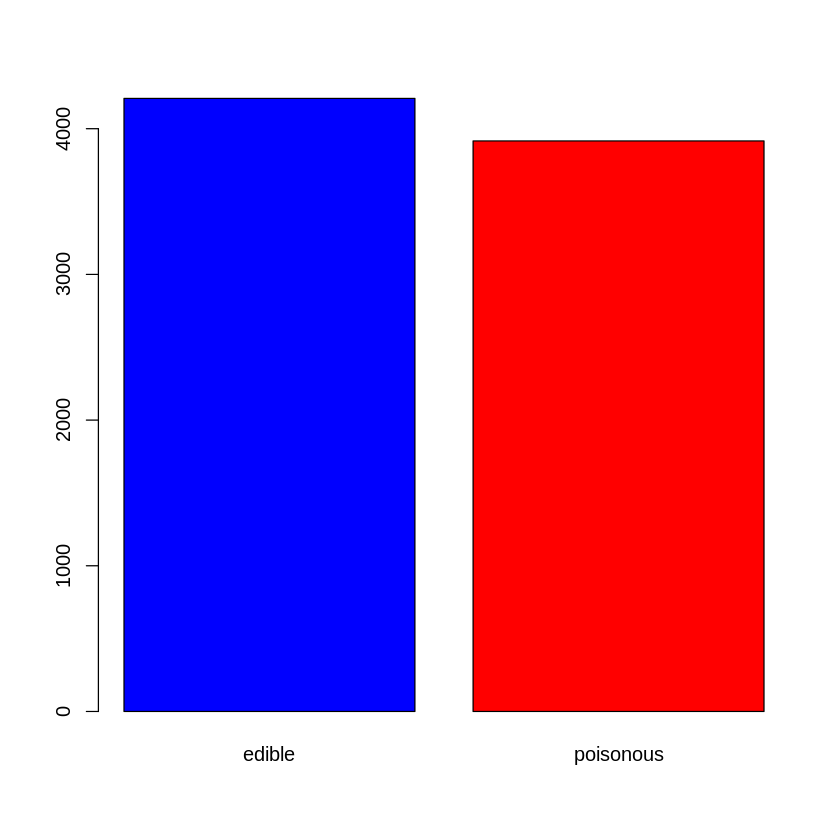

In [7]:
#::GMG::Proporción de clases en el dataset
table(dataset$class)
barplot(height = table(dataset$class),
        col = c('blue','red'),
        names.arg = c('edible','poisonous'))

In [8]:
#::GMG::Dos observaciones
#::nota 1:: 8. Missing Attribute Values: 2480 of them (denoted by "?"), all for
#         attribute #11 (stalk-root)
# en http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
#
summary(dataset$stalk.root)

?    b    c    e    r 
2480 3776  556 1120  192

In [9]:
#::nota 2::veil-type solamente tiene un valor 'p'
#
# veil_type_idx <- which(colnames(dataset) == "veil-type")
# dataset <- dataset[-veil_type_idx]
summary(dataset$veil.type)

p 
8124

In [10]:
#::GMG::Anotamos de forma apropiada los missing values
dataset_complete <- dataset
dataset_complete$stalk.root[dataset_complete$stalk.root == '?'] <- NA
summary(dataset_complete$stalk.root)

?    b    c    e    r NA's 
   0 3776  556 1120  192 2480

In [11]:
#::GMG::Decido deshacerme de todas las instancias con NAs
#       https://www.statmethods.net/input/missingdata.html
dataset_complete <- dataset_complete[complete.cases(dataset_complete),]
any(is.na(dataset_complete))

[1] FALSE

In [12]:
#::GMG::Me deshago el level '?' en stalk_root
# https://www.rdocumentation.org/packages/base/versions/3.5.1/topics/droplevels
dataset_complete$stalk.root<-droplevels(dataset_complete$stalk.root)
summary(dataset_complete$stalk.root)

b    c    e    r 
3776  556 1120  192

In [13]:
#::GMG::Nos cargamos el feature que vale siempre lo mismo y ni aporta
#       nada, nos quedamos con 22 factores
dataset_complete$veil.type <- NULL

In [14]:
str(dataset_complete)

'data.frame':	5644 obs. of  22 variables:
 $ class                   : Factor w/ 2 levels "e","p": 2 1 1 2 1 1 1 1 2 1 ...
 $ cap.shape               : Factor w/ 6 levels "b","c","f","k",..: 6 6 1 6 6 6 1 1 6 1 ...
 $ cap.surface             : Factor w/ 4 levels "f","g","s","y": 3 3 3 4 3 4 3 4 4 3 ...
 $ cap.color               : Factor w/ 10 levels "b","c","e","g",..: 5 10 9 9 4 10 9 9 9 10 ...
 $ bruises                 : Factor w/ 2 levels "f","t": 2 2 2 2 1 2 2 2 2 2 ...
 $ odor                    : Factor w/ 9 levels "a","c","f","l",..: 7 1 4 7 6 1 1 4 7 1 ...
 $ gill.attachment         : Factor w/ 2 levels "a","f": 2 2 2 2 2 2 2 2 2 2 ...
 $ gill.spacing            : Factor w/ 2 levels "c","w": 1 1 1 1 2 1 1 1 1 1 ...
 $ gill.size               : Factor w/ 2 levels "b","n": 2 1 1 2 1 1 1 1 2 1 ...
 $ gill.color              : Factor w/ 12 levels "b","e","g","h",..: 5 5 6 6 5 6 3 6 8 3 ...
 $ stalk.shape             : Factor w/ 2 levels "e","t": 1 1 1 1 2 1 1 1 1 1 ...
 $ stalk.r

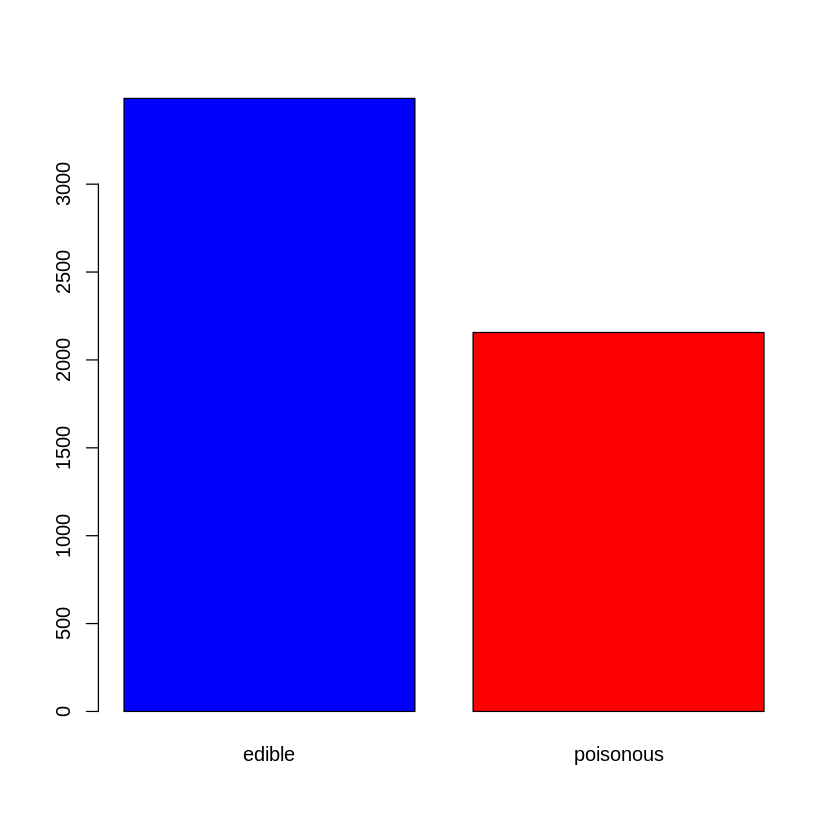

In [15]:
#::GMG::Vemos si hemos dañado el balance de clases ... 
#       un poco, pero creo que podemos aceptarlo por el momento, veremos (!)
barplot(height = table(dataset_complete$class),
        col = c('blue','red'),
        names.arg = c('edible','poisonous'))

### Punto 1 (3 puntos):

Considerar uno de los algoritmos de asociación vistos en clase y obtener las reglas representativas del dataset fijando los parámetros de aprendizaje (soporte, confianza, etc...). 

#### Previo

[Hashler et al. arulesViz](https://cran.r-project.org/web/packages/arulesViz/vignettes/arulesViz.pdf) pp.3

> Before we start, we set the number of displayed significant digits to two to make the output
> easier to read, and we set the seed for the random number generator for predictability.

In [45]:
options(digits = 2)
set.seed(1234)

#### Bibliotecas 

In [46]:
library("arules")

In [47]:
library("arulesViz")

#### Eclat

In [48]:
#::GMG::Creamos las transacciones de base
transactions.ms <- as(dataset_complete, 'transactions')
transactions.ms

transactions in sparse format with
 5644 transactions (rows) and
 117 items (columns)

In [49]:
summary(transactions.ms)

transactions as itemMatrix in sparse format with
 5644 rows (elements/itemsets/transactions) and
 117 columns (items) and a density of 0.19 

most frequent items:
     veil.color=w gill.attachment=f     ring.number=o       gill.size=b 
             5636              5626              5488              4940 
   gill.spacing=c           (Other) 
             4620             97858 

element (itemset/transaction) length distribution:
sizes
  22 
5644 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     22      22      22      22      22      22 

includes extended item information - examples:
       labels variables levels
1     class=e     class      e
2     class=p     class      p
3 cap.shape=b cap.shape      b

includes extended transaction information - examples:
  transactionID
1             1
2             2
3             3

In [50]:
#::GMG::Fijo los parámetros iniciales de support y maxlen y aplico eclat
#  para obtener los itemsets
itemsets <- eclat(transactions.ms, parameter = list(supp = 0.1, maxlen = 5))
itemsets

Eclat

parameter specification:
 tidLists support minlen maxlen            target   ext
    FALSE     0.1      1      5 frequent itemsets FALSE

algorithmic control:
 sparse sort verbose
      7   -2    TRUE

Absolute minimum support count: 564 

create itemset ... 
set transactions ...[99 item(s), 5644 transaction(s)] done [0.01s].
sorting and recoding items ... [54 item(s)] done [0.00s].
creating bit matrix ... [54 row(s), 5644 column(s)] done [0.00s].
writing  ... [57733 set(s)] done [0.06s].
Creating S4 object  ... done [0.01s].


set of 57733 itemsets 

In [65]:
summary(itemsets)

set of 57733 itemsets

most frequent items:
     veil.color=w gill.attachment=f     ring.number=o       gill.size=b 
            16108             16104             15924             14740 
   gill.spacing=c           (Other) 
            13818            185514 

element (itemset/transaction) length distribution:sizes
    1     2     3     4     5 
   54   727  4340 15380 37232 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     4.0     5.0     4.5     5.0     5.0 

summary of quality measures:
    support         count     
 Min.   :0.10   Min.   : 566  
 1st Qu.:0.11   1st Qu.: 648  
 Median :0.13   Median : 748  
 Mean   :0.16   Mean   : 900  
 3rd Qu.:0.17   3rd Qu.: 976  
 Max.   :1.00   Max.   :5636  

includes transaction ID lists: FALSE 

mining info:
            data ntransactions support
 transactions.ms          5644     0.1

In [51]:
#::GMG::Genero las reglas a partir de los itemsets fijando la métrica 
#       confidence
rules <- ruleInduction(itemsets, transactions.ms, confidence = .9)

#### Análisis General

Analizar los resultados en términos generales:

* ¿Cuantas reglas se han generado?

In [52]:
rules

set of 157180 rules 

In [66]:
summary(rules)

set of 157180 rules

rule length distribution (lhs + rhs):sizes
     2      3      4      5 
   305   4922  32183 119770 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     5.0     5.0     4.7     5.0     5.0 

summary of quality measures:
    support       confidence        lift        itemset     
 Min.   :0.10   Min.   :0.90   Min.   :0.9   Min.   :    1  
 1st Qu.:0.11   1st Qu.:1.00   1st Qu.:1.0   1st Qu.:11660  
 Median :0.13   Median :1.00   Median :1.5   Median :23920  
 Mean   :0.16   Mean   :0.99   Mean   :1.7   Mean   :25982  
 3rd Qu.:0.17   3rd Qu.:1.00   3rd Qu.:1.9   3rd Qu.:40099  
 Max.   :1.00   Max.   :1.00   Max.   :6.8   Max.   :57679  

mining info:
            data ntransactions support confidence
 transactions.ms          5644     0.1        0.9

In [53]:
inspect(head(rules))

    lhs                    rhs                 support confidence lift itemset
[1] {gill.size=b,                                                             
     stalk.shape=e,                                                           
     veil.color=w,                                                            
     habitat=p}         => {gill.spacing=c}        0.1          1  1.2       1
[2] {gill.spacing=c,                                                          
     stalk.shape=e,                                                           
     veil.color=w,                                                            
     habitat=p}         => {gill.size=b}           0.1          1  1.1       1
[3] {gill.spacing=c,                                                          
     gill.size=b,                                                             
     veil.color=w,                                                            
     habitat=p}         => {stalk.shape=e}         0

* ¿Existe alguna regla redundante?, ¿Cuántas?

In [56]:
#::GMG::Según S04_Association_Rules
length(rules[is.redundant(rules)])

[1] 152273

In [57]:
#::GMG::Filtramos las redundantes
rules.filtered <- rules[!is.redundant(rules)]
length(rules.filtered)

[1] 4907

* ¿Existe alguna regla que incluya la variable objetivo: `Class=edible` ó `Class=poisonous`?, ¿Cuantas?

In [58]:
#::GMG::Para eso hay que usar inspect()/length() + subset()
length(subset(rules.filtered, 
              subset = rhs %in% c("class=e") | lhs %in% c("class=e") |
                       rhs %in% c("class=p") | lhs %in% c("class=p")
             )
      )

[1] 1469

* De cara a ser utilizada como modelo predictivo es adecuado que la variable objetivo se encuentre en el consecuente de la regla de asociación, ¿se da esta propiedad en alguna regla?

In [59]:
#::GMG::Queremos que class se encuentre en rhs, claro :)
length(subset(rules.filtered, 
              subset = rhs %in% c("class=e") | rhs %in% c("class=p")
             )
      )

[1] 354

#### Análisis Detallado

* Considerar los subconjuntos de reglas con ambas clases como consecuente e ilustrar las variables implicadas en cada caso. Considerar alguno de los grafos vistos para apoyar las conclusiones obtenidas.

NOTA: Usar soportes superiores a 0.1 para evitar problemas de memoria.

In [60]:
#::GMG::Seleccionamos solamente las que tienen como consecuente class
rules.class.filtered <- subset(rules.filtered, 
                               subset = rhs %in% c("class=e") | rhs %in% c("class=p")
                              )

In [89]:
inspect(head(rules.class.filtered,n = 10))

     lhs                                         rhs       support confidence
[1]  {stalk.color.above.ring=g}               => {class=e} 0.1     1.00      
[2]  {stalk.color.below.ring=g}               => {class=e} 0.1     1.00      
[3]  {cap.color=e,odor=n}                     => {class=e} 0.1     1.00      
[4]  {cap.color=e,stalk.shape=t}              => {class=e} 0.1     1.00      
[5]  {cap.color=e,bruises=t}                  => {class=e} 0.1     1.00      
[6]  {cap.color=e,ring.type=p}                => {class=e} 0.1     1.00      
[7]  {cap.color=e,gill.attachment=f}          => {class=e} 0.1     0.99      
[8]  {cap.color=e,ring.number=o}              => {class=e} 0.1     1.00      
[9]  {cap.color=e,stalk.root=b}               => {class=e} 0.1     1.00      
[10] {cap.color=e,stalk.surface.above.ring=s} => {class=e} 0.1     1.00      
     lift itemset
[1]  1.6  1495   
[2]  1.6  2965   
[3]  1.6  3642   
[4]  1.6  3874   
[5]  1.6  4050   
[6]  1.6  4180   
[7]  1.6  4266  

In [80]:
summary(rules.class.filtered)

set of 354 rules

rule length distribution (lhs + rhs):sizes
  2   3   4   5 
 11 109 144  90 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     3.0     4.0     3.9     5.0     5.0 

summary of quality measures:
    support       confidence        lift         itemset     
 Min.   :0.10   Min.   :0.90   Min.   :1.46   Min.   : 1495  
 1st Qu.:0.12   1st Qu.:0.95   1st Qu.:1.57   1st Qu.:29511  
 Median :0.15   Median :1.00   Median :1.62   Median :38290  
 Mean   :0.18   Mean   :0.98   Mean   :1.86   Mean   :35080  
 3rd Qu.:0.23   3rd Qu.:1.00   3rd Qu.:2.45   3rd Qu.:45289  
 Max.   :0.50   Max.   :1.00   Max.   :2.62   Max.   :57409  

mining info:
            data ntransactions support confidence
 transactions.ms          5644     0.1        0.9

In [61]:
#::GMG::Divido las reglas entre el caso class=e y el caso class=p
rules.class.edible <- subset(rules.class.filtered, 
                             subset = rhs %in% c("class=e")
                            )
rules.class.poisonous <- subset(rules.class.filtered, 
                                subset = rhs %in% c("class=p")
                               )
paste('venenoso:', length(rules.class.poisonous), 'comestible:', length(rules.class.edible))

[1] "venenoso: 104 comestible: 250"

**::GMG::** Según una comunicación de Wlodek Duch (1997) que viene en la [descripción del dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names) en el repositorio original de UCI tenemos las reglas más simples, que podemos usar como *workbench*:

> Disjunctive rules for poisonous mushrooms, from most general
	to most specific:
>
>	P_1) odor=NOT(almond.OR.anise.OR.none)
>	     120 poisonous cases missed, 98.52% accuracy
>
>	P_2) spore-print-color=green
>	     48 cases missed, 99.41% accuracy
>        
>	P_3) odor=none.AND.stalk-surface-below-ring=scaly.AND.
>	          (stalk-color-above-ring=NOT.brown) 
>	     8 cases missed, 99.90% accuracy
>         
>	P_4) habitat=leaves.AND.cap-color=white
>	         100% accuracy     
>
>	Rule P_4) may also be
>
>	P_4') population=clustered.AND.cap_color=white
>
>	These rule involve 6 attributes (out of 22). Rules for edible
>	mushrooms are obtained as negation of the rules given above, for
>	example the rule:
>
>	odor=(almond.OR.anise.OR.none).AND.spore-print-color=NOT.green
>
>	gives 48 errors, or 99.41% accuracy on the whole dataset.
>
>	Several slightly more complex variations on these rules exist,
>	involving other attributes, such as gill_size, gill_spacing,
>	stalk_surface_above_ring, but the rules given above are the simplest
>	we have found.


In [90]:
inspect(head(rules.class.poisonous,n = 10))

     lhs                                          rhs       support confidence
[1]  {cap.color=y,stalk.shape=e,stalk.root=b}  => {class=p} 0.11    1.00      
[2]  {cap.color=y,gill.size=b,stalk.root=b}    => {class=p} 0.11    1.00      
[3]  {cap.color=y,gill.spacing=c,stalk.root=b} => {class=p} 0.11    1.00      
[4]  {cap.color=y,stalk.root=b}                => {class=p} 0.11    0.93      
[5]  {cap.color=y,bruises=f}                   => {class=p} 0.12    1.00      
[6]  {stalk.surface.below.ring=k}              => {class=p} 0.23    1.00      
[7]  {ring.type=l}                             => {class=p} 0.23    1.00      
[8]  {stalk.surface.above.ring=k}              => {class=p} 0.24    1.00      
[9]  {spore.print.color=h}                     => {class=p} 0.28    1.00      
[10] {odor=f}                                  => {class=p} 0.28    1.00      
     lift itemset
[1]  2.6  12000  
[2]  2.6  12014  
[3]  2.6  12015  
[4]  2.4  12041  
[5]  2.6  12043  
[6]  2.6  19214  
[7]  

In [112]:
#::GMG::Ejemplos para encontrar reglas dentro del conjunto ...
# {cap.color=y,bruises=f} => {class=p} 
#inspect(subset(rules.class.poisonous, 
#               subset = lhs %in% c('cap.color=y') &
#                        lhs %in% c('bruises=f')
#              )
#       )
# {cap.color=y,stalk.shape=e,stalk.root=b}  => {class=p}
inspect(subset(rules.class.poisonous, 
               subset = lhs %ain% c('cap.color=y','stalk.shape=e','stalk.root=b')
              )
       )

    lhs                                         rhs       support confidence
[1] {cap.color=y,stalk.shape=e,stalk.root=b} => {class=p} 0.11    1         
    lift itemset
[1] 2.6  12000  


In [119]:
#::GMG::Intento encontrar alguna regla de las descritas por Duch 
#       Los valores de los campos con una sola letra no son obvios y es mejor
#       mirarse '7. Attribute Information' de
#  http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
#::nota::lo ideal hubiera sido poner los valores completos en vez de una única letra
#        en la parte de preparación de los datos (lo que yo he llamado punto 0)
# 
#  p.e P_4':= population=clustered.AND.cap_color=white ->
#             {population=c,cap.color=w} => {class=p}
#      P_2:= spore-print-color=green
#            {spore.print.color=r} => {class=p}
#  no se encuentran (!)
#
#inspect(subset(rules.class.poisonous, 
#               subset = lhs %in% c('spore.print.color=r')))
#
#     P_1:= odor=NOT(almond.OR.anise.OR.none) ->
#           !(odor=a | odor=l | odor=n)
# incluye a todas las que hemos obtenido(!!)
#inspect(subset(rules.class.poisonous, 
#               subset = !(lhs %in% c('odor=a') |
#                          lhs %in% c('odor=l') |
#                          lhs %in% c('odor=n'))
#              )
#       )

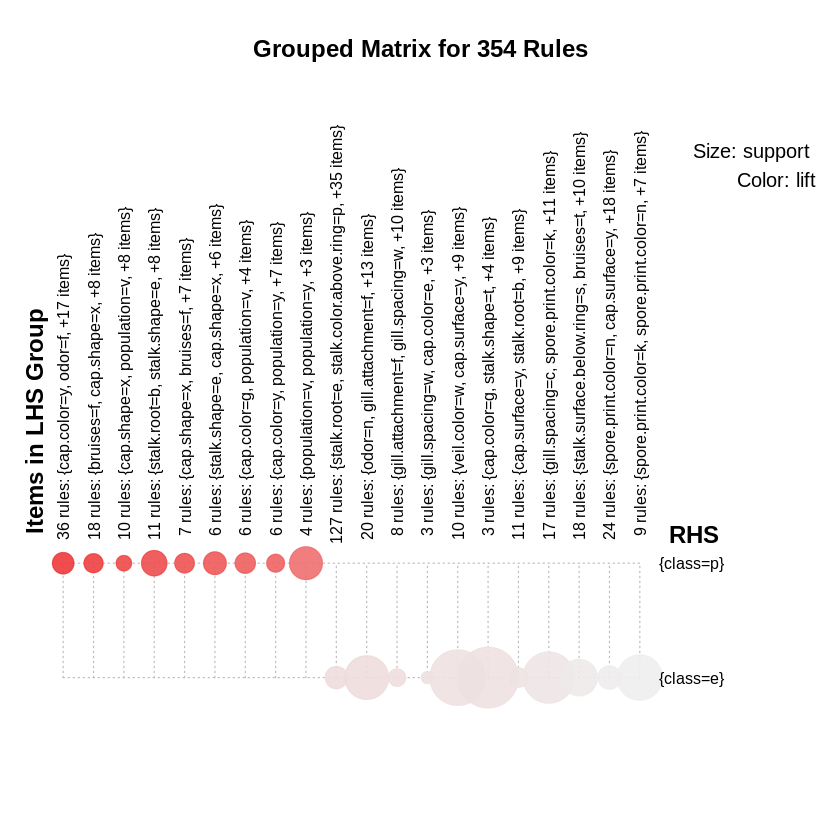

In [120]:
#::GMG::Ejemplo de análisis gráfico de reglas
#  5. Grouped matrix-based visualization, hashler et al. pp.11-16
plot(rules.class.filtered, method = "grouped")

#### Venenosas (class=p)

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


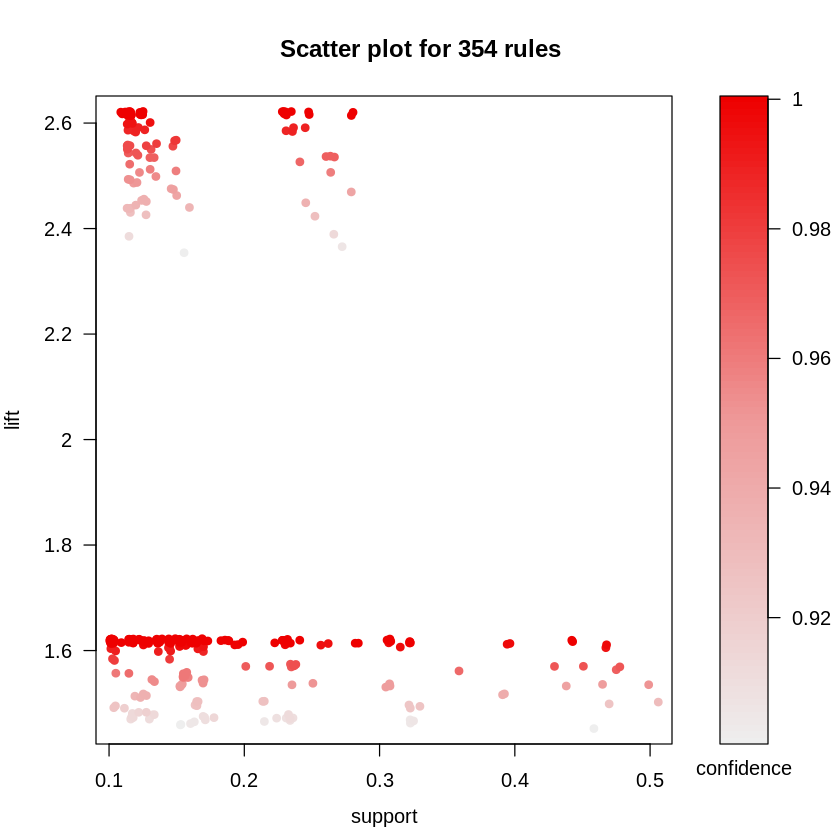

In [99]:
plot(rules.class.poisonous, measure = c("support", "lift"), shading = "confidence")

In [98]:
#::GMG::Vamos a ver cuántas reglas salen con lift superior a 2.6
length(subset(rules.class.poisonous, subset = lift > 2.6))

[1] 44

In [106]:
#::GMG::... mayor 'lift'
inspect(head(sort(rules.class.poisonous, by="lift"), n = 5))

    lhs                                          rhs       support confidence
[1] {cap.color=y,stalk.shape=e,stalk.root=b}  => {class=p} 0.11    1         
[2] {cap.color=y,gill.size=b,stalk.root=b}    => {class=p} 0.11    1         
[3] {cap.color=y,gill.spacing=c,stalk.root=b} => {class=p} 0.11    1         
[4] {cap.color=y,bruises=f}                   => {class=p} 0.12    1         
[5] {stalk.surface.below.ring=k}              => {class=p} 0.23    1         
    lift itemset
[1] 2.6  12000  
[2] 2.6  12014  
[3] 2.6  12015  
[4] 2.6  12043  
[5] 2.6  19214  


To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


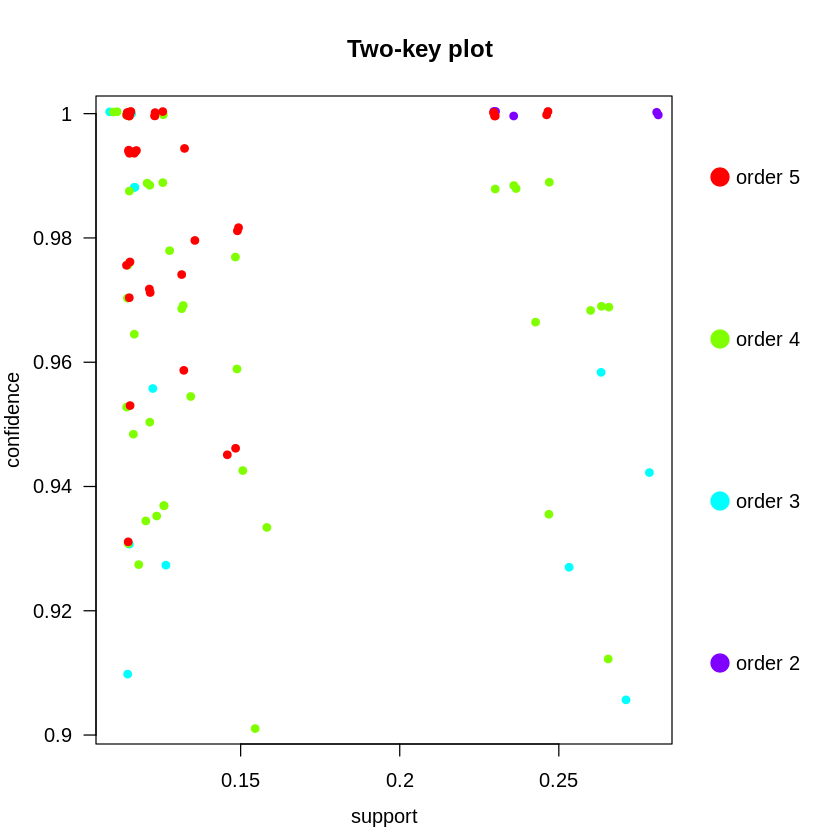

In [108]:
#::GMG:: La complejidad máxima de las reglas es 5, i.e. lhs(4) -> rhs(1)
plot(rules.class.poisonous, method = "two-key plot")

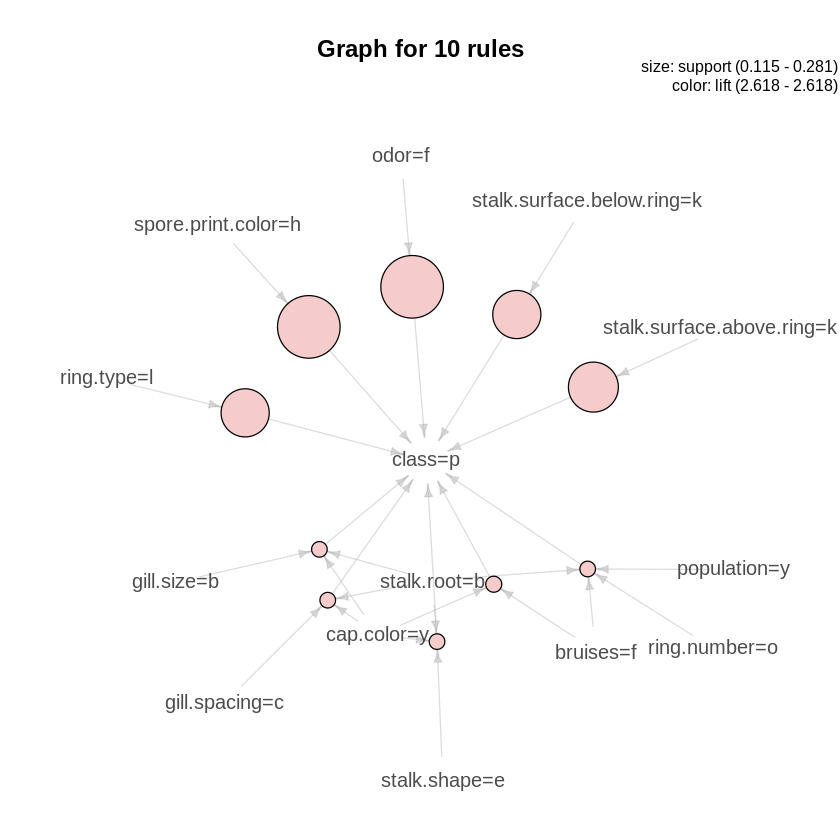

In [124]:
plot(head(rules.class.poisonous, by="lift", n = 10), method = "graph")

In [ ]:
#::GMG::Vamos a ver las class=p que tienen mayor soporte ...
#inspect(head(sort(rules.class.poisonous, by = "support"), n = 5))

In [ ]:
#::GMG::... mayor confianza
#inspect(head(sort(rules.class.poisonous, by="confidence"), n = 5))

In [ ]:
#::GMG::Dibujamos las reglas class=p (hay que interpretarlo ...)
#plot(rules.class.poisonous)

::GMG::[PTE] **Interpretación**

#### Comestibles (class=e)

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


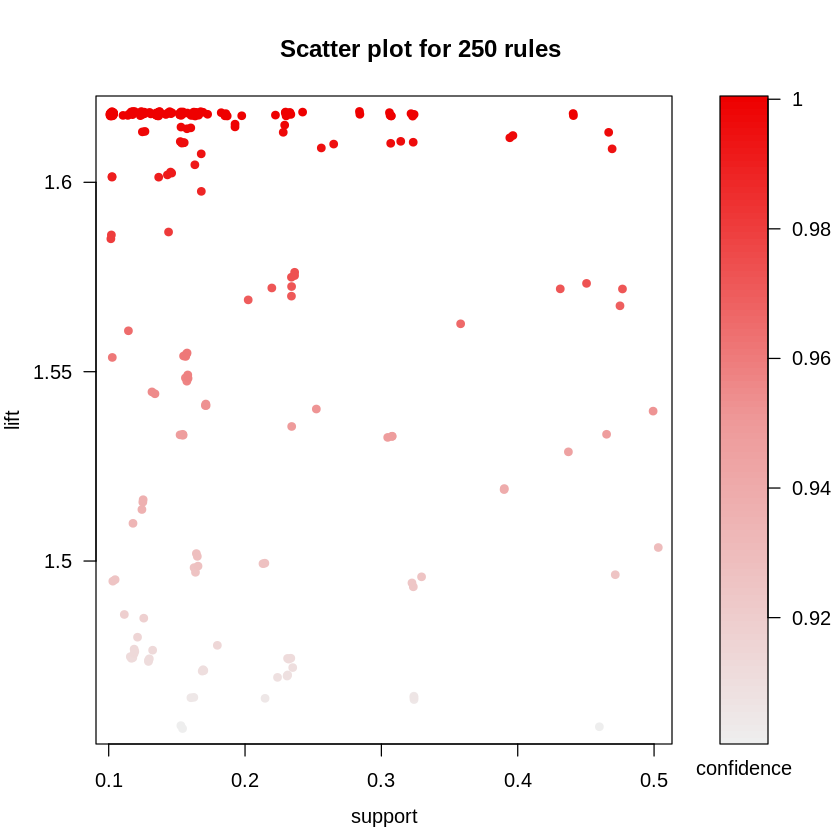

In [100]:
plot(rules.class.edible, measure = c("support", "lift"), shading = "confidence")

In [105]:
#::GMG::Vamos a ver cuántas reglas salen con lift superior a 2.6
length(subset(rules.class.edible, subset = lift > 1.6))

[1] 154

In [107]:
#::GMG::... mayor 'lift'
inspect(head(sort(rules.class.edible, by="lift"), n = 5))

    lhs                            rhs       support confidence lift itemset
[1] {stalk.color.above.ring=g}  => {class=e} 0.1     1          1.6  1495   
[2] {stalk.color.below.ring=g}  => {class=e} 0.1     1          1.6  2965   
[3] {cap.color=e,odor=n}        => {class=e} 0.1     1          1.6  3642   
[4] {cap.color=e,stalk.shape=t} => {class=e} 0.1     1          1.6  3874   
[5] {cap.color=e,bruises=t}     => {class=e} 0.1     1          1.6  4050   


To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


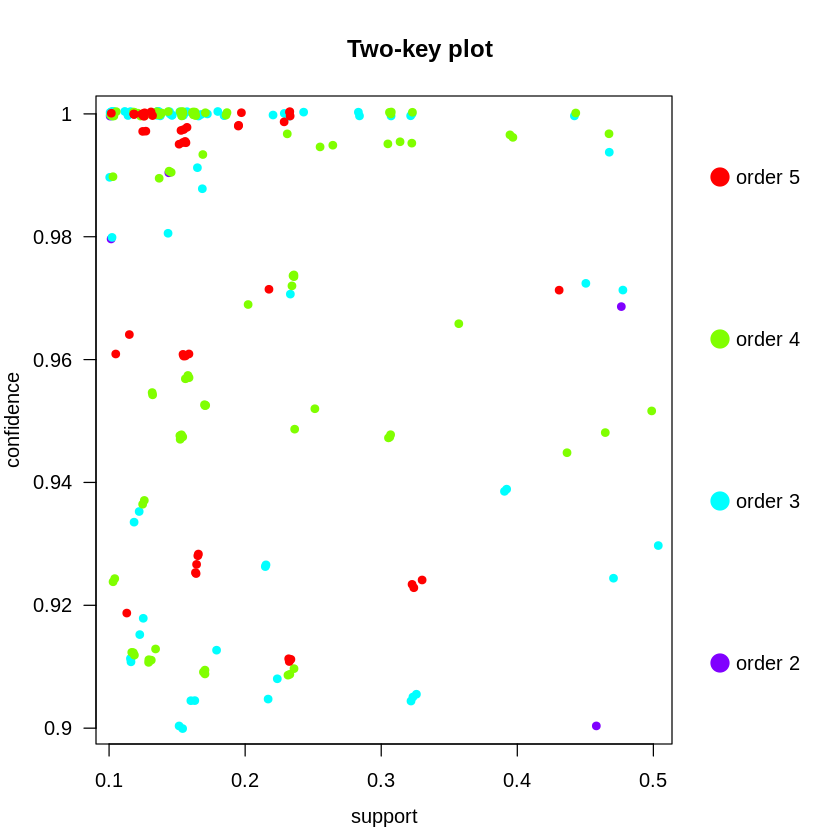

In [109]:
#::GMG:: La complejidad máxima de las reglas es 5, i.e. lhs(4) -> rhs(1)
plot(rules.class.edible, method = "two-key plot")

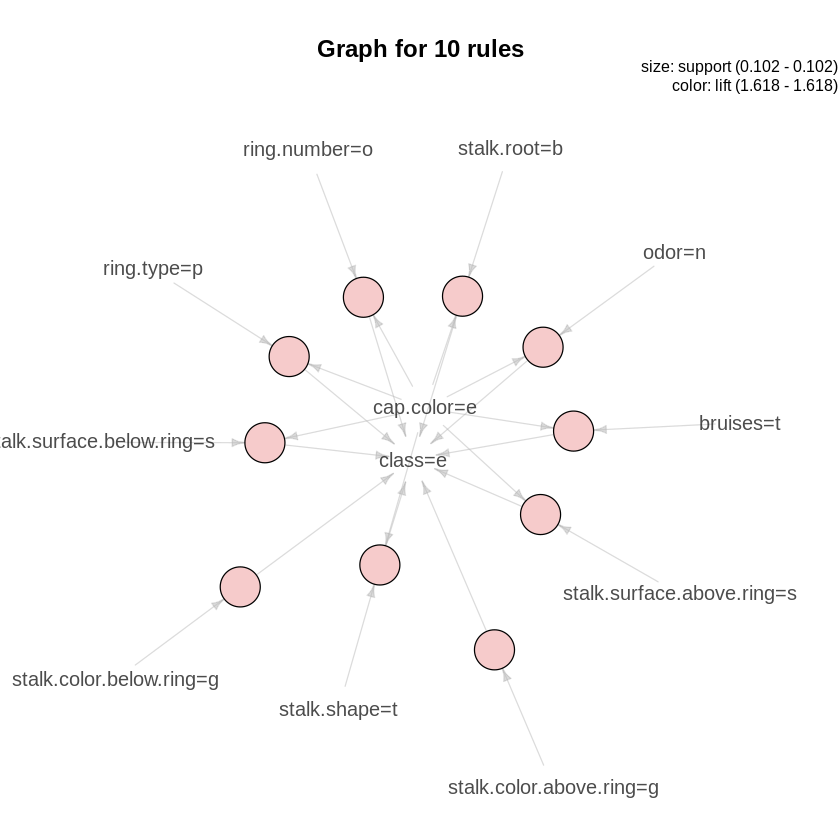

In [125]:
plot(head(rules.class.edible, by="lift", n = 10), method = "graph")

In [ ]:
#::GMG::Vamos a ver las class=e que tienen mayor soporte ...
#inspect(head(sort(rules.class.edible, by = "support"), n = 5))

In [ ]:
#::GMG::... mayor confianza
#inspect(head(sort(rules.class.edible, by="confidence"), n = 5))

In [ ]:
#::GMG::Dibujamos las reglas class=p (hay que interpretarlo ...)
#plot(rules.class.edible)

::GMG::[PTE] **Interpretación**

### Punto 2 (4 puntos):

En este apartado aplicaremos árboles de clasificación para obtener un modelo que permita clasificar una nueva entrada. Para ello, vamos a utilizaremos el paquete `CaReT`. Este paquete (y los demás que hemos visto para trabajar con árboles en `R`) no aceptan objetos del tipo `transactions` como los del apartado anterior. Por tanto, hemos preparado un fichero *csv* con el dataset *Mushrooms*; puedes descargarlo desde esta aquí:
https://github.com/SantanderMetGroup/Master-Data-Science/tree/master/Data_mining/datasets. Lee el dataset con la función `read.csv`.  
Ahora ya tenemos un data.frame con el que podemos empezar a trabajar. En primer lugar tendremos que eliminar la columna 17 (`veil.type`), ya que contiene un único nivel y daría errores en `CaReT`(esta columna podría eliminarse también en el caso de las reglas de asociación ya que no aporta información al dataset).  
Nuestro objetivo será encontrar la configuración (profundidad) óptima del árbol. Para ello, partiremos el dataset en dos subconjuntos indpendedientes de train y test (75% y 25% del total, respectivamente). Sobre el dataset de train, aplicaremos una cross-validación con 3 folds y la repetiremos 50 veces (recuerda que los árboles son sensibles a la partición train/test que se considere). 

* ¿Cuál es la configuración óptima del árbol? ¿Hay alguna diferencia entre el árbol *completo* y el óptimo? ¿Por qué crees que ocurre esto?
* ¿Cuáles son las dos variables que mayor peso tienen a la hora de clasificar? Entrena un nuevo árbol considerando como predictores únicamente esas dos variables. ¿Qué resultados obtienes? 
* Entrena un nuevo árbol considerando como predictores cualesquiera otras dos variables que no sean las utilizadas en la pregunta anterior. ¿Cuál es el error de test de este árbol?

### Punto 3 (3 puntos):

Por un lado, las ramas del árbol pueden ser interpretadas como reglas de forma similar a las obtenidas por el algoritmo de reglas aplicado. Por ejemplo, en el caso del árbol obtenido con el dataset `Play Tennis` puede obtenerse las siguientes `reglas`: SI Outlook = Overcast -> Play Tennis = Yes ó SI (Outlook = Sunny) AND (Humidity = Normal) -> Play Tennis = Yes, cuya confianza asociada viene dada por la frecuencia relativa de cada caso en esa rama del árbol. Por otro lado, considerando las reglas que implican a nuestra variable objetivo tendríamos un `modelo` similar al dado por el árbol. Considerar y comparar ambas aproximaciones (p.e. ¿coinciden los antecedentes de las reglas? ¿alguna de las variables más frecuentes como antecedente en las reglas se corresponde con alguna de las variables con mayor capacidad de discriminación? etc.). 